In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

In [ ]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#'''
Dataset_Name = "COVIDx_CT_2A_Kaggle"
base_dir = 'drive/My Drive/COVID_19_Dataset/COVIDx CT-2A Kaggle/'

#train_dir = os.path.join(base_dir, 'train_patch')
#test_dir = os.path.join(base_dir, 'test_patch')

work_dir = "drive/My Drive/COVID_19_Dataset/COVIDx CT-2A Kaggle/Records/"
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 32
#'''

In [ ]:
#'''
train_file = base_dir+"train_COVIDx_CT-2A.txt"
train_df_original = pd.read_csv(train_file, delimiter = " ", header=None)
train_df_original.columns = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
train_df_original.head()
#'''

In [ ]:
#'''
train_df = train_df_original[['filename', 'class']]

for i in range(train_df.shape[0]):
    filename = train_df['filename'][i]
    file_full_path = f"{base_dir}/2A_images/{filename}"
    train_df['filename'][i] = file_full_path
    #train_df['class'][i] = str(train_df['class'][i])

print(f"train_df['filename'][0] = {train_df['filename'][0]}")
train_df.tail()
#'''

In [ ]:
train_df['class'] = train_df['class'].astype(str)

In [ ]:
#'''
val_file = base_dir+"val_COVIDx_CT-2A.txt"
val_df_original = pd.read_csv(val_file, delimiter = " ", header=None)
val_df_original.columns = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
val_df_original.head()
#'''

In [ ]:
#'''
val_df = val_df_original[['filename', 'class']]

for i in range(val_df.shape[0]):
    filename = val_df['filename'][i]
    file_full_path = f"{base_dir}/2A_images/{filename}"
    val_df['filename'][i] = file_full_path
    #val_df['class'][i] = str(val_df['class'][i])

print(f"val_df['filename'][0] = {val_df['filename'][0]}")
val_df.tail()
#'''

In [ ]:
val_df['class'] = val_df['class'].astype(str)

In [ ]:
test_file = base_dir+"test_COVIDx_CT-2A.txt"
test_df_original = pd.read_csv(test_file, delimiter = " ", header=None)
test_df_original.columns = ['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
test_df_original.head()

filename  class  xmin  ymin  xmax  ymax
0  NCP_341_1834_0022.png      2     0   130   512   429
1  NCP_341_1834_0023.png      2     0   130   512   429
2  NCP_341_1834_0024.png      2     0   130   512   429
3  NCP_341_1834_0029.png      2     0   128   512   430
4  NCP_341_1834_0030.png      2     0   128   512   430

In [ ]:
test_df = test_df_original[['filename', 'class']]

for i in range(test_df.shape[0]):
    filename = test_df['filename'][i]
    file_full_path = f"{base_dir}/2A_images/{filename}"
    test_df['filename'][i] = file_full_path
    #test_df['class'][i] = str(test_df['class'][i])
    
print(f"test_df['filename'][0] = {test_df['filename'][0]}")
test_df.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


test_df['filename'][0] = ../input/covidxct/2A_images/NCP_341_1834_0022.png


filename  class
25653  ../input/covidxct/2A_images/radiopaedia_29_864...      2
25654  ../input/covidxct/2A_images/radiopaedia_29_864...      2
25655  ../input/covidxct/2A_images/radiopaedia_29_864...      2
25656  ../input/covidxct/2A_images/radiopaedia_29_864...      2
25657  ../input/covidxct/2A_images/radiopaedia_29_864...      2

In [ ]:
test_df['class'] = test_df['class'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#'''
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=None,
        x_col='filename', 
        y_col='class',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = True,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical'
)
#'''

In [ ]:
#'''
num_classes = len(train_generator.class_indices)
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")
#'''

In [ ]:
#'''
val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=None,
        x_col='filename', 
        y_col='class',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = True,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical'
)
#'''

In [ ]:
#'''
num_classes = len(val_generator.class_indices)
total_val_data = val_generator.samples

print(f"total_val_data = {total_val_data}")
print(f"val_generator.image_shape = {val_generator.image_shape}")
print(f"num_classes = {num_classes}")
#'''

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=None,
        x_col='filename', 
        y_col='class',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical'
)

Found 25658 validated image filenames belonging to 3 classes.


In [ ]:
num_classes = len(test_generator.class_indices)
total_test_data = test_generator.samples

print(f"total_test_data = {total_test_data}")
print(f"test_generator.image_shape = {test_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_test_data = 25658
test_generator.image_shape = (256, 256, 3)
num_classes = 3


In [ ]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TL.3D.DenseNet201" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{test_generator.image_shape[1]}p.DataFlow.TVT" # +str(img_size)+"p"
dataset

'COVIDx_CT_2A_Kaggle.rgb.(256, 256).DataFlow.TrainValTest'

In [ ]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [ ]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 300 # 300, 5
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.1024.1024.2048" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".Flatten.l2.{str(l2_val)}.run_1" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.COVIDx_CT_2A_Kaggle.rgb.(256, 256).DataFlow.TrainValTest.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
log_name = log.COVIDx_CT_2A_Kaggle.rgb.(256, 256).DataFlow.TrainValTest.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.log


In [ ]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
#model.summary()
#'''

In [ ]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

In [ ]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

In [ ]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
)

print("OPTIMIZER =", OPTIMIZER)

In [ ]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [ ]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

In [ ]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

In [ ]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

In [ ]:
'''
Record: :
;
---

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, AUC: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[2],4), round(result[0],4), epochs_completed, checkpointer_name))


In [ ]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

In [ ]:
'''
Record: :
;
---

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, AUC: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[2],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


In [ ]:
# metrics=['accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
result2 

In [ ]:
TP = result2[3]
TN = result2[4]
FP = result2[5]
FN = result2[6]
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")

In [ ]:
'''
run_1: accuracy=0.9896, sensitivity=recall=0.9896, specificity=0.9949, PPV=precision=0.9897, NPV=0.9948, f1_score=0.9896, auc=0.99

'''

In [ ]:
accuracy = round(result2[1], 4)
sensitivity = round((TP / (TP+FN)), 4)
specificity = round((TN / (FP+TN)), 4)
#PPV = round((TP / (TP+FP)), 4)
NPV = round((TN / (TN+FN)), 4)
precision = round((TP / (TP+FP)), 4) # PPV and precision are same.
recall = sensitivity # sensitivity and recall are same.
f1_score = round((2*precision*recall) / (precision+recall), 4)
auc = round(result2[1], 2)

print(f"accuracy={accuracy}, sensitivity=recall={sensitivity}, specificity={specificity}, PPV=precision={precision}, NPV={NPV}, f1_score={f1_score}, auc={auc}")

In [ ]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

In [ ]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

In [ ]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

In [ ]:
len(test_generator.labels)

25658

In [ ]:
Y_pred_loaded = np.load(f"../input/notebooke960295c6e-y-pred/notebooke960295c6e_Y_pred.COVIDx_CT_2A_Kaggle.rgb.(256 256).DataFlow.TrainValTest.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.e.npy", allow_pickle=True)
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (25658, 3)


In [ ]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [ ]:
y_true = test_generator.classes

In [ ]:
list_class_names_in_generator = list(test_generator.class_indices.values())
list_class_names_in_generator[:5]

[0, 1, 2]

In [ ]:
TP_class_0 = 0
TP_class_1 = 0
TP_class_2 = 0

TN_class_0 = 0
TN_class_1 = 0
TN_class_2 = 0

FP_class_0 = 0
FP_class_1 = 0
FP_class_2 = 0

FN_class_0 = 0
FN_class_1 = 0
FN_class_2 = 0

for true_class,pred_class in zip(y_true,y_pred):
    # Correct classifications:
    if true_class == pred_class:
        if pred_class == 0:
            TP_class_0 += 1
        else:
            TN_class_0 += 1
            
        if pred_class == 1:
            TP_class_1 += 1
        else:
            TN_class_1 += 1
            
        if pred_class == 2:
            TP_class_2 += 1
        else:
            TN_class_2 += 1
            
    # Incorrect classifications:
    elif true_class != pred_class:
        if pred_class == 0:
            FP_class_0 += 1
        else:
            FN_class_0 += 1

        if pred_class == 1:
            FP_class_1 += 1
        else:
            FN_class_1 += 1

        if pred_class == 2:
            FP_class_2 += 1
        else:
            FN_class_2 += 1

In [ ]:
print(f"TP_class_0 = {TP_class_0}")
print(f"TP_class_1 = {TP_class_1}")
print(f"TP_class_2 = {TP_class_2}")

print(f"\nTN_class_0 = {TN_class_0}")
print(f"TN_class_1 = {TN_class_1}")
print(f"TN_class_2 = {TN_class_2}")

print(f"\nFP_class_0 = {FP_class_0}")
print(f"FP_class_1 = {FP_class_1}")
print(f"FP_class_2 = {FP_class_2}")

print(f"\nFN_class_0 = {FN_class_0}")
print(f"FN_class_1 = {FN_class_1}")
print(f"FN_class_2 = {FN_class_2}")

TP_class_0 = 12079
TP_class_1 = 7370
TP_class_2 = 5943

TN_class_0 = 13313
TN_class_1 = 18022
TN_class_2 = 19449

FP_class_0 = 69
FP_class_1 = 44
FP_class_2 = 153

FN_class_0 = 197
FN_class_1 = 222
FN_class_2 = 113


In [ ]:
# Sensitivity: (Normal=0, Pneumonia=1, COVID-19=2)
# Sensitivity and Recall are same.
sensitivity_class_0 = round((TP_class_0 / (TP_class_0+FN_class_0)), 4)
sensitivity_class_1 = round((TP_class_1 / (TP_class_1+FN_class_1)), 4)
sensitivity_class_2 = round((TP_class_2 / (TP_class_2+FN_class_2)), 4)

print(f"sensitivity_class_0 = {sensitivity_class_0}")
print(f"sensitivity_class_1 = {sensitivity_class_1}")
print(f"sensitivity_class_2 = {sensitivity_class_2}")

sensitivity_class_0 = 0.984
sensitivity_class_1 = 0.9708
sensitivity_class_2 = 0.9813


In [ ]:
# PPV: (Normal=0, Pneumonia=1, COVID-19=2)
# PPV and Precision are same.
ppv_class_0 = round((TP_class_0 / (TP_class_0+FP_class_0)), 4)
ppv_class_1 = round((TP_class_1 / (TP_class_1+FP_class_1)), 4)
ppv_class_2 = round((TP_class_2 / (TP_class_2+FP_class_2)), 4)

print(f"ppv_class_0 = {ppv_class_0}")
print(f"ppv_class_1 = {ppv_class_1}")
print(f"ppv_class_2 = {ppv_class_2}")

ppv_class_0 = 0.9943
ppv_class_1 = 0.9941
ppv_class_2 = 0.9749


In [ ]:
# Specificity: (Normal=0, Pneumonia=1, COVID-19=2)
specificity_class_0 = round((TN_class_0 / (FP_class_0+TN_class_0)), 4)
specificity_class_1 = round((TN_class_1 / (FP_class_1+TN_class_1)), 4)
specificity_class_2 = round((TN_class_2 / (FP_class_2+TN_class_2)), 4)

print(f"specificity_class_0 = {specificity_class_0}")
print(f"specificity_class_1 = {specificity_class_1}")
print(f"specificity_class_2 = {specificity_class_2}")

specificity_class_0 = 0.9948
specificity_class_1 = 0.9976
specificity_class_2 = 0.9922


In [ ]:
# NPV: (Normal=0, Pneumonia=1, COVID-19=2)
npv_class_0 = round((TN_class_0 / (TN_class_0+FN_class_0)), 4)
npv_class_1 = round((TN_class_1 / (TN_class_1+FN_class_1)), 4)
npv_class_2 = round((TN_class_2 / (TN_class_2+FN_class_2)), 4)

print(f"npv_class_0 = {npv_class_0}")
print(f"npv_class_1 = {npv_class_1}")
print(f"npv_class_2 = {npv_class_2}")

npv_class_0 = 0.9854
npv_class_1 = 0.9878
npv_class_2 = 0.9942


In [ ]:
np_metrics = np.array([[sensitivity_class_0, ppv_class_0, specificity_class_0, npv_class_0],
              [sensitivity_class_1, ppv_class_1, specificity_class_1, npv_class_1],
              [sensitivity_class_2, ppv_class_2, specificity_class_2, npv_class_2]])
np_metrics.shape

(3, 4)

In [ ]:
df_metrics = pd.DataFrame(np_metrics)
df_metrics.columns=['Sensitivity', 'PPV', 'Specificity', 'NPV']
df_metrics.index=['Normal', 'Pneumonia', 'COVID-19']
df_metrics

Sensitivity     PPV  Specificity     NPV
Normal          0.9840  0.9943       0.9948  0.9854
Pneumonia       0.9708  0.9941       0.9976  0.9878
COVID-19        0.9813  0.9749       0.9922  0.9942

In [ ]:
df_metrics.to_csv('metrics_COVIDx_CT_2A_notebooke960295c6e_v3.csv')

In [ ]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [ ]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (25658,)
np_y_pred_rearranged.shape = (25658,)
np_y_true_rearranged: [2 2 2 ... 2 2 2]
np_y_pred_rearranged: [2 2 2 ... 2 2 2]


In [ ]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (25658,)

y_true[-5:] = [2, 2, 2, 2, 2]
y_pred[-5:] = [2 2 2 2 2]

np_y_true_rearranged[-5:] = [2 2 2 2 2]
np_y_pred_rearranged[-5:] = [2 2 2 2 2]

np.unique(np_y_true_rearranged) = [0 1 2]
np.unique(np_y_pred_rearranged) = [0 1 2]


In [ ]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[12079    14   152]
 [   24  7370     1]
 [   45    30  5943]]


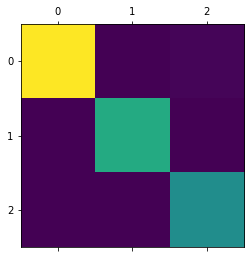

In [ ]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [ ]:
# Normal=0, Pneumonia=1, and COVID-19=2
df_conf_matrix = pd.DataFrame(conf_matrix, index = ['Normal','Pneumonia','COVID-19'],
                  columns = ['Normal','Pneumonia','COVID-19'])

img_path = ./conf_matrix_COVIDx_CT_2A_Kaggle.rgb.(256, 256).DataFlow.TrainValTest.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


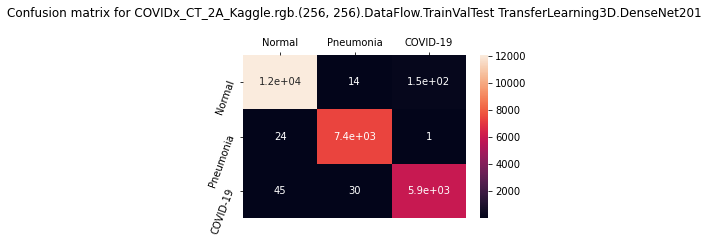

In [ ]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (5,3))
plt.title(title)
ax = sn.heatmap(df_conf_matrix, annot=True)
ax.xaxis.tick_top() # x axis on top
plt.yticks(rotation=70) 

img_path = work_dir+'conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [ ]:
test_generator.class_indices.keys()

In [ ]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

In [ ]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [ ]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

In [ ]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

In [ ]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)